# Implementación de un modelo de Deep Learning

> Datos Generales

Nombre: Edna Jacqueline Zavala Ortega

Matrícula: A01750480

> Dataset

El dataset contiene 15,000 imágenes de 3 clases de calzado: Botas, Sandalias y Zapatos casuales. Por ello, se realizó una CNN para clasificarlas.

El dataset se pre-procesó usando otro script y se crearon 3 conjuntos de datos: de entrenamiento, validación y pruebas.

El dataset original se puede encontrar en el siguiente enlace: https://www.kaggle.com/datasets/hasibalmuzdadid/shoe-vs-sandal-vs-boot-dataset-15k-images

El notebook perteneciente al preprocesamiento de los datos se encuentra en el siguiente enlace: https://colab.research.google.com/drive/1KGqpqiWNWaASduHXivfvtkgdoF_hTpgo?usp=sharing y se puede encontrar una copia dentro del repositorio.

> Instalar e importar los módulos necesarios

In [1]:
!pip install gdown

# to upgrade
!pip install --upgrade gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for gdown: filename=gdown-4.5.3-py3-none-any.whl size=14841 sha256=5e0e695ad8048f572a90b0034084a8c211ccb7802acfa5e03af6168d55c60556
  Stored in directory: /root/.cache/pip/wheels/94/8d/0b/bdcd83555c3555f91a33f6c2384428d9f163c7d75ab0d272b4
Successfully built gdown
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0


In [70]:
import cv2
import os.path
from os import path
import numpy as np
import os, pathlib
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory

%matplotlib inline

> Descargar el dataset

In [3]:
!gdown https://drive.google.com/uc?id=19CY6O-IFw40yfJXy36jOxdKRs9Pi1tWa

Downloading...
From: https://drive.google.com/uc?id=19CY6O-IFw40yfJXy36jOxdKRs9Pi1tWa
To: /content/dataset-a01750480.zip
100% 51.5M/51.5M [00:00<00:00, 135MB/s]


In [4]:
!unzip -qq 'dataset-a01750480.zip'

> Cargar el dataset desde el directorio

In [5]:
# Tensorflow <2.10 use
current_directory = '/content/dataset-a01750480/content/drive/Shareddrives/Concentracion/Bloque II/Momento de Retroalimentacion/Deep Learning/Dataset'

# Definir el tamaño de las imágenes, el tamaño del batch y definir el directorio base
new_base_dir = pathlib.Path(current_directory)
image_size = (255,255)
batch_size = 16 # Múltiplos de 8

# Esta lista controlará el orden de las clases (mismo orden alfanumérico)
class_names = ["Boot", "Sandal", "Shoe"]

# Train dataset
# Se navega al directorio y se extraen los archivos, se cambia el tamaño y se realiza el one hot encoding de los labels
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=image_size,
    labels="inferred",
    label_mode="categorical",
    shuffle=True,
    batch_size=batch_size)

# Validation dataset
validation_dataset = image_dataset_from_directory(
    new_base_dir / "val",
    image_size=image_size,
    labels="inferred",
    label_mode="categorical",
    shuffle=True,
    batch_size=batch_size)

# Test dataset
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=image_size,
    labels="inferred",
    label_mode="categorical",
    shuffle=True,
    batch_size=batch_size)

Found 9600 files belonging to 3 classes.
Found 2400 files belonging to 3 classes.
Found 3000 files belonging to 3 classes.


In [6]:
# Diccionario para interpretar el resultado
class_decoder = {
    0: "Boot",
    1: "Sandal",
    2: "Shoe"
}

In [9]:
# Verificar que los datos se hayan cargado correctamente
for data_batch, labels_batch in train_dataset:
  print("data batch shape:", data_batch.shape)
  print(data_batch[0])
  print(labels_batch[0])
  print("labels batch shape:", labels_batch.shape)
  break

data batch shape: (16, 255, 255, 3)
tf.Tensor(
[[[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 ...

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]

 [[255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]
  ...
  [255. 255. 255.]
  [255. 255. 255.]
  [255. 255. 255.]]], shape=(255, 255, 3), dtype=float32)
tf.Tensor([0. 0. 1.], shape=(3,), dtype=float32)
labels batch shape: (16, 3)


> CNN

Para la arquitectura se tienen principalmente los siguientes tipos de capas:

1. **Data Augmentation:** se tienen transformaciones como rotaciones, zoom, o se les da la vuelta a las imágenes.

2. **Rescaling:** se reescalan los valores de los pixeles de las imágenes a valores entre 0 y 1.

3. **Capas convolutivas:** tienen filtros cuyas dimensiones (kernel_size) son un hiperparámetro. Tienen la principal función de extraer los features.

4. **Max Pooling:** las capas de pooling reducen las dimensiones de los feature maps y resumen los features presentes en ellos, lo que hace que el modelo sea más resistente a cambios de posición en las imágenes. En el caso de max pooling se selecciona el elemento con un valor mayor dentro de la región del filtro. 

5. **Flatten:**reducir el tamaño del ouput para ser proce.

6. **Capas Densas:**se colocan al final de la arquitectura de la CNN y se conectan por completo a todas las neuronas de salida. Tiene la finalidad de clasificar la imagen. 

La función de activación es ReLu, la cual regresa la entrada si es positiva, de lo contrario, regresará cero. Esta función se ha caracterizado por obtener buenos resultados y ser fácil de entrenar.

Para la última capa densa se seleccionó la función de activación softmax, ya que al ser un problema de clasificación, se busca un vector de probabilidades.



#### Primera Iteración

Selección de Hiperparámetros

In [10]:
# Tamaño de los filtros (kernel_size) para las capas convolutivas                                                                                                                                                                                   
kernel_size=(3,3) # Se suelen usar de tamaño 3,5,7
# Tamamos batches de 2x2 para disminuir la informacion obtenida del Conv2D                                                                                                                                                                                  
pool_size=(2, 2) 

In [32]:
first_model = keras.Sequential([keras.Input(shape=(255, 255, 3)),
                          # Data Augmentation
                          layers.RandomFlip(),
                          layers.RandomRotation(0.1),
                          layers.RandomZoom(0.2),
                          # Rescale Input to values between 0 and 1
                          layers.Rescaling(1./255),
                          # Convolutional and Pooling Layers
                          # Para esta arquitectura se utiliza un mayor número de filtros a menor número de filtros
                          layers.Conv2D(filters=256, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.Conv2D(filters=256, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.MaxPooling2D(pool_size=pool_size),
                          layers.Conv2D(filters=64, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.Conv2D(filters=64, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.MaxPooling2D(pool_size=pool_size),
                          layers.Conv2D(filters=64, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.Conv2D(filters=64, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.MaxPooling2D(pool_size=pool_size),
                          layers.Conv2D(filters=32, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.Conv2D(filters=32, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.MaxPooling2D(pool_size=pool_size),
                          layers.Dropout(0.4),
                          # Flatten to enter Dense Layers
                          layers.Flatten(),
                          # Dense Layers: se debe considerar que el número de salidas es > 3000
                          keras.layers.Dense(100, activation ='relu'),
                          keras.layers.Dense(50, activation ='relu'),
                          # Output Layer
                          keras.layers.Dense(3, activation ='softmax')])
first_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 255, 255, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 255, 255, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 255, 255, 3)       0         
                                                                 
 rescaling_3 (Rescaling)     (None, 255, 255, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 255, 255, 256)     7168      
                                                                 
 conv2d_25 (Conv2D)          (None, 255, 255, 256)     590080    
                                                      

In [12]:
# Optimizador: ADAM con learning rate 0.1
opt = tf.keras.optimizers.Adam(learning_rate=0.1) 
# Metricas: categorical accuracy y AUC
cat_accuracy = tf.keras.metrics.CategoricalAccuracy()
auc = tf.keras.metrics.AUC()
# Compilar el modelo y definir como función de pérdida categorical cross entropy
first_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=[cat_accuracy, auc])

In [13]:
# Cambiar el directorio para guardar el callback en el entorno de ejecución y evitar la latencia de la conexión con Google Drive
os.chdir('/content/')
!ls

dataset-a01750480  dataset-a01750480.zip  sample_data


In [15]:
# Cantidad de epochs
epochs=10
# Callbacks que monitorean el valor de la función de pérdida en el conjunto de validación
callbacks_first = [
    # Guarda el mejor modelo considerando que la función de pérdida en el conjunto de validación debe ser la mínima
    keras.callbacks.ModelCheckpoint(
        filepath="first_model.keras",
        save_best_only=True,
        monitor="val_loss",
        mode="min"),
    # Detiene el entrenamiento si el valor de la función de pérdida no decrece en un máximo de 2 epochs
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta = 0.0001,
        patience=2,
        mode="min",
        restore_best_weights=True)
]
# Entrenar la CNN
with tf.device('/device:GPU:0'):
  history = first_model.fit(
      train_dataset,
      epochs=epochs,
      validation_data=validation_dataset,
      callbacks=callbacks_first)

Epoch 1/10
600/600 [==============================] - 573s 920ms/step - loss: 1.0992 - categorical_accuracy: 0.3311 - auc: 0.4950 - val_loss: 1.0987 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000
Epoch 2/10
600/600 [==============================] - 547s 911ms/step - loss: 1.0988 - categorical_accuracy: 0.3221 - auc: 0.4940 - val_loss: 1.0987 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000
Epoch 3/10
600/600 [==============================] - 547s 912ms/step - loss: 1.0988 - categorical_accuracy: 0.3289 - auc: 0.4949 - val_loss: 1.0987 - val_categorical_accuracy: 0.3333 - val_auc: 0.5000


Se puede observar que en este caso, el entrenamiento terminó en la tercera época dado que el valor de la función de pérdida en el conjunto de validación no disminuyó en 2 épocas consecutivas. 

Además, este modelo tiene un accuracy de 0.33 en el conjunto de validación, lo que indica **underfitting**.

In [30]:
# Path de donde se encuentra el modelo
model_path = '/content/first_model.keras'

# Cargar el modelo
test_model = keras.models.load_model(
    model_path)

In [ ]:
# convert the history.history dict to a pandas DataFrame:     
first_model_hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'first-model-history.csv'
with open(hist_csv_file, mode='w') as f:
    first_model_hist_df.to_csv(f)

first_model_hist_df.head()
first_model_hist_df.rename(columns={"auc_4": "auc", "val_auc_4": "val_auc"}, inplace=True)

In [31]:
# Métricas del entrenamiento
train_cat_accuracy = first_model_hist_df["categorical_accuracy"]
train_loss = first_model_hist_df["loss"]
train_auc = first_model_hist_df["auc"]

# Métricas del conjunto de validación
val_cat_accuracy = first_model_hist_df["val_categorical_accuracy"]
val_loss = first_model_hist_df["val_loss"]
val_auc = first_model_hist_df["val_auc"]

# Generar una lista para graficar los valores respecto a las épocas
epochs = range(1, len(train_cat_accuracy) + 1)

# Categorical accuracy del conjunto de entrenamiento vs validación
plt.plot(epochs, train_cat_accuracy, "bo", label="Training categorical accuracy")
plt.plot(epochs, val_cat_accuracy, "b", label="Validation categorical accuracy")
plt.title("Training and validation categorical accuracy")
plt.legend()
plt.savefig("first_model_cat_accuracy.png")


# Loss del conjunto de entrenamiento vs validación
plt.figure()
plt.plot(epochs, train_loss, "ro", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.savefig("first_model_loss.png")

# AUC del conjunto de entrenamiento vs validación
plt.figure()
plt.plot(epochs, train_auc, "go", label="Training AUC")
plt.plot(epochs, val_auc, "g", label="Validation AUC")
plt.title("Training and validation AUC")
plt.legend()
plt.show()
plt.savefig("first_model_auc.png")

KeyError: ignored

Los valores de loss y accuracy en 

In [18]:
first_model.save('/content/drive/Shareddrives/Concentracion/Bloque II/Momento de Retroalimentacion/Deep Learning/FirstModel')

#### Segunda Iteración

De acuerdo con el primer resultado, se hicieron los siguientes cambios:
* Se retiraron las capas de data augmentation (ya que generaban demasiado ruido al modelo).

* Se cambió el número de filtros por un número menor, pues dado que el tamaño de la imagen era de 255x255 los filtros se estaban encimando mucho.

* Se disminuyó el learning rate del optimizador Adam. Cambió de 0.1 a 0.001

* Se agregó dropout del 40% de las neuronas entre las capas densas.

* Se aumentó el número de neuronas de las capas densas (100-> 2000, 50-> 1000).

Selección de Hiperparámetros

In [61]:
# Tamaño de los filtros (kernel_size) para las capas convolutivas                                                                                                                                                                                   
kernel_size=(3,3) # Se suelen usar de tamaño 3,5,7
# Tamamos batches de 2x2 para disminuir la informacion obtenida del Conv2D                                                                                                                                                                                  
pool_size=(2, 2) 

In [62]:
final_model = keras.Sequential([keras.Input(shape=(255, 255, 3)),
                          # Rescale Input to values between 0 and 1
                          layers.Rescaling(1./255),
                          # Convolutional and Pooling Layers
                          # Para esta arquitectura se utiliza un mayor número de filtros a menor número de filtros
                          layers.Conv2D(filters=120, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.Conv2D(filters=120, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.MaxPooling2D(pool_size=pool_size),
                          layers.Conv2D(filters=60, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.Conv2D(filters=60, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.MaxPooling2D(pool_size=pool_size),
                          layers.Conv2D(filters=30, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.Conv2D(filters=30, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.MaxPooling2D(pool_size=pool_size),
                          layers.Conv2D(filters=15, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.Conv2D(filters=15, kernel_size=kernel_size, padding = 'same', activation="relu"),
                          layers.MaxPooling2D(pool_size=pool_size),
                          layers.Dropout(0.4),
                          # Flatten to enter Dense Layers
                          layers.Flatten(),
                          # Dense Layers: se debe considerar que el número de salidas es > 3000
                          keras.layers.Dense(2000, activation ='relu'),
                          # Dropout para procurar que las neuronas generalicen y se diferencíen entre sí para aprender más sobre diversos features de las imágenes
                          layers.Dropout(0.4),
                          keras.layers.Dense(1000, activation ='relu'),
                          # Dropout
                          layers.Dropout(0.4),
                          # Output Layer
                          keras.layers.Dense(3, activation ='softmax')])
final_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 255, 255, 3)       0         
                                                                 
 conv2d_48 (Conv2D)          (None, 255, 255, 120)     3360      
                                                                 
 conv2d_49 (Conv2D)          (None, 255, 255, 120)     129720    
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 127, 127, 120)    0         
 g2D)                                                            
                                                                 
 conv2d_50 (Conv2D)          (None, 127, 127, 60)      64860     
                                                                 
 conv2d_51 (Conv2D)          (None, 127, 127, 60)      32460     
                                                      

In [63]:
# Optimizador: ADAM con learning rate 0.001
opt = tf.keras.optimizers.Adam(learning_rate=0.001) 
# Metricas: categorical accuracy y AUC
cat_accuracy = tf.keras.metrics.CategoricalAccuracy()
auc = tf.keras.metrics.AUC()
# Compilar el modelo y definir como función de pérdida categorical cross entropy
final_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=[cat_accuracy, auc])

In [64]:
# Cambiar el directorio para guardar el callback en el entorno de ejecución y evitar la latencia de la conexión con Google Drive
os.chdir('/content/')
!ls

dataset-a01750480      final-model-history.csv	resnet.keras
dataset-a01750480.zip  first_model.keras	sample_data
drive		       resnet-history.csv


In [65]:
# Cantidad de epochs
epochs=10

# Callbacks que monitorean el valor de la función de pérdida en el conjunto de validación
callbacks = [
    # Guarda el mejor modelo considerando que la función de pérdida en el conjunto de validación debe ser la mínima
    keras.callbacks.ModelCheckpoint(
        filepath="final_model.keras",
        save_best_only=True,
        monitor="val_loss",
        mode="min"),
    # Detiene el entrenamiento si el valor de la función de pérdida no decrece en un máximo de 3 epochs
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta = 0.0001,
        patience=3,
        mode="min",
        restore_best_weights=True)
]
# Entrenar la CNN
with tf.device('/device:GPU:0'):
  history = final_model.fit(
      train_dataset,
      epochs=epochs,
      validation_data=validation_dataset,
      callbacks=callbacks)

Epoch 1/10
600/600 [==============================] - 153s 253ms/step - loss: 1.1001 - categorical_accuracy: 0.3276 - auc_9: 0.4952 - val_loss: 1.0990 - val_categorical_accuracy: 0.3333 - val_auc_9: 0.5000
Epoch 2/10
600/600 [==============================] - 152s 253ms/step - loss: 1.0990 - categorical_accuracy: 0.3333 - auc_9: 0.4962 - val_loss: 1.0987 - val_categorical_accuracy: 0.3333 - val_auc_9: 0.5000
Epoch 3/10
600/600 [==============================] - 152s 253ms/step - loss: 1.0990 - categorical_accuracy: 0.3301 - auc_9: 0.4960 - val_loss: 1.0988 - val_categorical_accuracy: 0.3333 - val_auc_9: 0.5000
Epoch 4/10
600/600 [==============================] - 153s 254ms/step - loss: 1.0989 - categorical_accuracy: 0.3269 - auc_9: 0.4962 - val_loss: 1.0988 - val_categorical_accuracy: 0.3333 - val_auc_9: 0.5000
Epoch 5/10
600/600 [==============================] - 153s 255ms/step - loss: 1.0988 - categorical_accuracy: 0.3309 - auc_9: 0.5001 - val_loss: 1.0988 - val_categorical_accurac

In [41]:
# convert the history.history dict to a pandas DataFrame:     
final_model_hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'final-model-history.csv'
with open(hist_csv_file, mode='w') as f:
    final_model_hist_df .to_csv(f)

In [45]:
final_model_hist_df = pd.read_csv('final-model-history.csv')
final_model_hist_df.rename(columns={"auc_4": "auc", "val_auc_4": "val_auc"}, inplace=True)
final_model_hist_df.head()

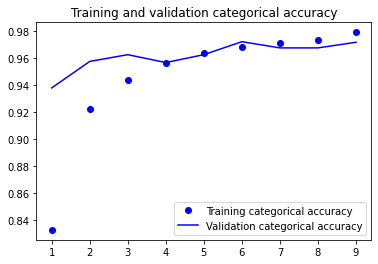

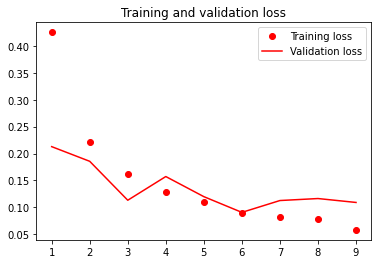

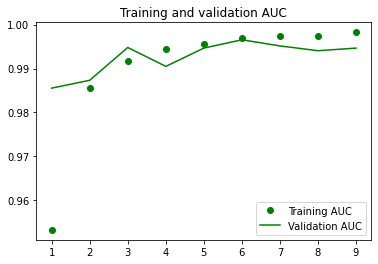

In [46]:
# Métricas del entrenamiento
train_cat_accuracy = final_model_hist_df["categorical_accuracy"]
train_loss = final_model_hist_df["loss"]
train_auc = final_model_hist_df["auc"]

# Métricas del conjunto de validación
val_cat_accuracy = final_model_hist_df["val_categorical_accuracy"]
val_loss = final_model_hist_df["val_loss"]
val_auc = final_model_hist_df["val_auc"]

# Generar una lista para graficar los valores respecto a las épocas
epochs = range(1, len(train_cat_accuracy) + 1)

# Categorical accuracy del conjunto de entrenamiento vs validación
plt.plot(epochs, train_cat_accuracy, "bo", label="Training categorical accuracy")
plt.plot(epochs, val_cat_accuracy, "b", label="Validation categorical accuracy")
plt.title("Training and validation categorical accuracy")
plt.legend()
plt.savefig("first_model_cat_accuracy.png")


# Loss del conjunto de entrenamiento vs validación
plt.figure()
plt.plot(epochs, train_loss, "ro", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.savefig("first_model_loss.png")

# AUC del conjunto de entrenamiento vs validación
plt.figure()
plt.plot(epochs, train_auc, "go", label="Training AUC")
plt.plot(epochs, val_auc, "g", label="Validation AUC")
plt.title("Training and validation AUC")
plt.legend()
plt.show()
plt.savefig("first_model_auc.png")

In [47]:
final_model.save('/content/drive/Shareddrives/Concentracion/Bloque II/Momento de Retroalimentacion/Deep Learning/FinalModel')

#### Transfer Learning: ResNet50

In [59]:
resnet = Sequential()

pretrained_model= tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(255,255,3),
    pooling='avg',classes=5,
    weights='imagenet')

for layer in pretrained_model.layers:
        layer.trainable=False

resnet.add(pretrained_model)
resnet.add(Flatten())
resnet.add(Dense(1000, activation='relu'))
resnet.add(Dropout(0.4))
resnet.add(Dense(1000, activation='relu'))
resnet.add(Dropout(0.4))
resnet.add(Dense(3, activation='softmax'))

resnet.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_8 (Flatten)         (None, 2048)              0         
                                                                 
 dense_24 (Dense)            (None, 1000)              2049000   
                                                                 
 dropout_18 (Dropout)        (None, 1000)              0         
                                                                 
 dense_25 (Dense)            (None, 1000)              1001000   
                                                                 
 dropout_19 (Dropout)        (None, 1000)              0         
                                                                 
 dense_26 (Dense)            (None, 3)                

In [60]:
# Optimizador: ADAM con learning rate 0.001
opt = tf.keras.optimizers.Adam(learning_rate=0.001) 
# Metricas: categorical accuracy y AUC
cat_accuracy = tf.keras.metrics.CategoricalAccuracy()
auc = tf.keras.metrics.AUC()
resnet.compile(optimizer=opt,loss='categorical_crossentropy',metrics=[cat_accuracy, auc])


# Callbacks que monitorean el valor de la función de pérdida en el conjunto de validación
resnet_callbacks = [
    # Guarda el mejor modelo considerando que la función de pérdida en el conjunto de validación debe ser la mínima
    keras.callbacks.ModelCheckpoint(
        filepath="resnet.keras",
        save_best_only=True,
        monitor="val_loss",
        mode="min"),
    # Detiene el entrenamiento si el valor de la función de pérdida no decrece en un máximo de 3 epochs
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        min_delta = 0.0001,
        patience=3,
        mode="min",
        restore_best_weights=True)
]

history = resnet.fit(train_dataset, validation_data=validation_dataset, epochs=10, callbacks=resnet_callbacks)

Epoch 1/10
600/600 [==============================] - 60s 92ms/step - loss: 0.2734 - categorical_accuracy: 0.9050 - auc_8: 0.9807 - val_loss: 0.1286 - val_categorical_accuracy: 0.9529 - val_auc_8: 0.9945
Epoch 2/10
600/600 [==============================] - 54s 90ms/step - loss: 0.1438 - categorical_accuracy: 0.9523 - auc_8: 0.9933 - val_loss: 0.0957 - val_categorical_accuracy: 0.9658 - val_auc_8: 0.9975
Epoch 3/10
600/600 [==============================] - 54s 90ms/step - loss: 0.1153 - categorical_accuracy: 0.9604 - auc_8: 0.9957 - val_loss: 0.0719 - val_categorical_accuracy: 0.9733 - val_auc_8: 0.9980
Epoch 4/10
600/600 [==============================] - 55s 91ms/step - loss: 0.0881 - categorical_accuracy: 0.9698 - auc_8: 0.9970 - val_loss: 0.0796 - val_categorical_accuracy: 0.9758 - val_auc_8: 0.9971
Epoch 5/10
600/600 [==============================] - 54s 89ms/step - loss: 0.0882 - categorical_accuracy: 0.9710 - auc_8: 0.9966 - val_loss: 0.0818 - val_categorical_accuracy: 0.9700 

In [54]:
# convert the history.history dict to a pandas DataFrame:     
resnet_hist_df = pd.DataFrame(history.history) 

# or save to csv: 
hist_csv_file = 'resnet-history.csv'
with open(hist_csv_file, mode='w') as f:
    resnet_hist_df.to_csv(f)

In [57]:
resnet_hist_df = pd.read_csv('resnet-history.csv')
resnet_hist_df.rename(columns={"auc_7": "auc", "val_auc_7": "val_auc"}, inplace=True)
resnet_hist_df.head()

,Unnamed: 0,loss,categorical_accuracy,auc,val_loss,val_categorical_accuracy,val_auc
0,0,0.279466,0.905208,0.979488,0.100002,0.962917,0.996940
1,1,0.137955,0.952917,0.993683,0.106664,0.960833,0.995498
2,2,0.117552,0.959792,0.994980,0.094930,0.971250,0.995607
3,3,0.100292,0.964063,0.996130,0.084139,0.971250,0.996345
4,4,0.093967,0.968646,0.996172,0.092041,0.968750,0.996286


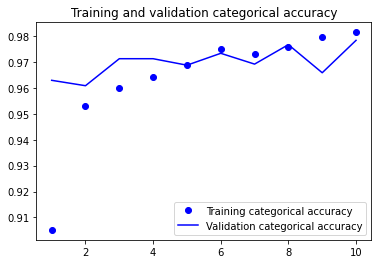

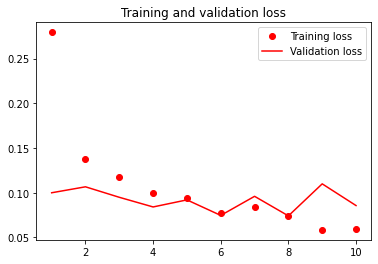

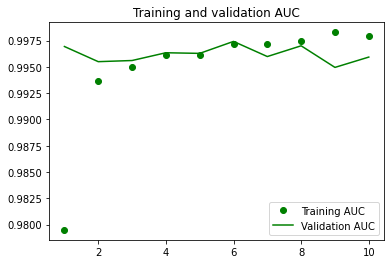

<Figure size 432x288 with 0 Axes>

In [58]:
# Métricas del entrenamiento
train_cat_accuracy = resnet_hist_df["categorical_accuracy"]
train_loss = resnet_hist_df["loss"]
train_auc = resnet_hist_df["auc"]

# Métricas del conjunto de validación
val_cat_accuracy = resnet_hist_df["val_categorical_accuracy"]
val_loss = resnet_hist_df["val_loss"]
val_auc = resnet_hist_df["val_auc"]

# Generar una lista para graficar los valores respecto a las épocas
epochs = range(1, len(train_cat_accuracy) + 1)

# Categorical accuracy del conjunto de entrenamiento vs validación
plt.plot(epochs, train_cat_accuracy, "bo", label="Training categorical accuracy")
plt.plot(epochs, val_cat_accuracy, "b", label="Validation categorical accuracy")
plt.title("Training and validation categorical accuracy")
plt.legend()
plt.savefig("resnet_cat_accuracy.png")


# Loss del conjunto de entrenamiento vs validación
plt.figure()
plt.plot(epochs, train_loss, "ro", label="Training loss")
plt.plot(epochs, val_loss, "r", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.savefig("resnet_loss.png")

# AUC del conjunto de entrenamiento vs validación
plt.figure()
plt.plot(epochs, train_auc, "go", label="Training AUC")
plt.plot(epochs, val_auc, "g", label="Validation AUC")
plt.title("Training and validation AUC")
plt.legend()
plt.show()
plt.savefig("resnet_auc.png")

#### Pruebas

> CNN

In [84]:
# Path de donde se encuentra el modelo
model_path = '/content/final_model.keras'

# Cargar el modelo
test_model = keras.models.load_model(
    model_path)

# Proporcionar el conjunto de prueba al modelo
test_loss, test_acc, test_auc = test_model.evaluate(test_dataset)

print(f"Test Categorical accuracy: {test_acc:.3f}")
print(f"Test loss: {test_loss:.3f}")
print(f"Test AUC: {test_auc:.3f}")

188/188 [==============================] - 17s 90ms/step - loss: 1.0987 - categorical_accuracy: 0.3333 - auc_9: 0.5000
Test Categorical accuracy: 0.333
Test loss: 1.099
Test AUC: 0.500


> ResNet50

In [85]:
# Path de donde se encuentra el modelo
model_path = '/content/resnet.keras'

# Cargar el modelo
test_resnet_model = keras.models.load_model(
    model_path)

# Proporcionar el conjunto de prueba al modelo
test_loss, test_acc, test_auc = test_resnet_model.evaluate(test_dataset)

print(f"Test Categorical accuracy: {test_acc:.3f}")
print(f"Test loss: {test_loss:.3f}")
print(f"Test AUC: {test_auc:.3f}")

188/188 [==============================] - 15s 75ms/step - loss: 0.0801 - categorical_accuracy: 0.9707 - auc_8: 0.9972
Test Categorical accuracy: 0.971
Test loss: 0.080
Test AUC: 0.997


#### Predicciones

In [67]:
# Función para preprocesar la imagen
dimensions = (255,255)
def preprocess_image(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image,dimensions)
    image = np.expand_dims(image, axis=0)
    return image

> CNN

In [75]:
folder_directory = '/content/predictions'

classes=[]
prediction_images = os.listdir(folder_directory)

In [77]:
prediction_images = ['boots-3.jpg',
 'sandal-1.jpeg',
 'boots-2.jpg',
 'boots-1.jpg']

1/1 [==============================] - 0s 53ms/step
/content/predictions/boots-3.jpg
/content/predictions/sandal-1.jpeg
/content/predictions/boots-2.jpg
/content/predictions/boots-1.jpg


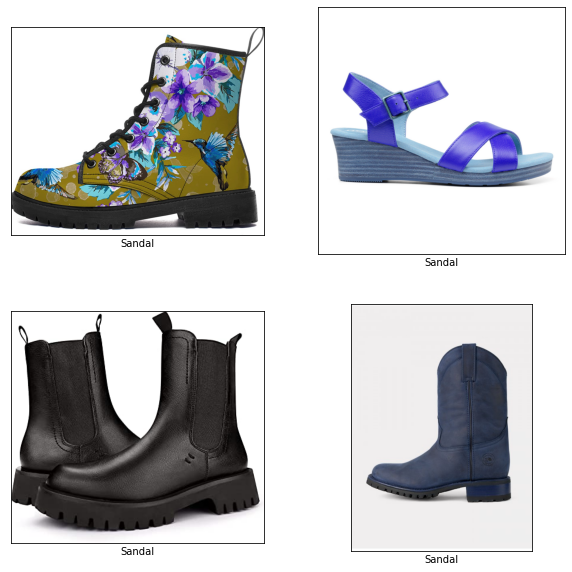

In [83]:
folder_directory = '/content/predictions/'

classes=[]
#prediction_images = os.listdir(folder_directory)

for image in prediction_images:
  test_image = preprocess_image(os.path.join(folder_directory, image))
  prediction = test_model.predict(test_image)
  result = np.argmax(prediction)
  classes.append(class_decoder[result])

# plt.axis("off")

# plt.imshow(array_to_img(test_image[0]))

plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    print(os.path.join(folder_directory, prediction_images[i]))
    image = cv2.imread(os.path.join(folder_directory, prediction_images[i]))
    plt.imshow(image)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(classes[i])
plt.show()

> ResNet 50

1/1 [==============================] - 0s 21ms/step
/content/predictions/boots-3.jpg
/content/predictions/sandal-1.jpeg
/content/predictions/boots-2.jpg
/content/predictions/boots-1.jpg


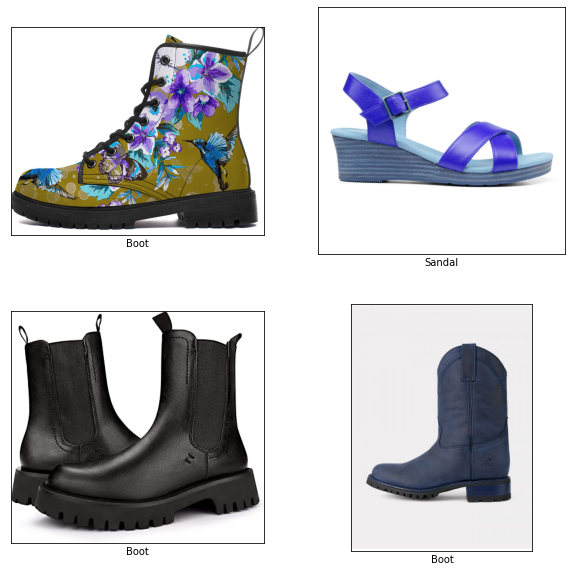

In [86]:
folder_directory = '/content/predictions/'

classes=[]
#prediction_images = os.listdir(folder_directory)

for image in prediction_images:
  test_image = preprocess_image(os.path.join(folder_directory, image))
  prediction = test_resnet_model.predict(test_image)
  result = np.argmax(prediction)
  classes.append(class_decoder[result])

# plt.axis("off")

# plt.imshow(array_to_img(test_image[0]))

plt.figure(figsize=(10,10))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    print(os.path.join(folder_directory, prediction_images[i]))
    image = cv2.imread(os.path.join(folder_directory, prediction_images[i]))
    plt.imshow(image)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(classes[i])
plt.show()